In [1]:
from pathlib import Path

import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader

from datasets_.kinetics_700 import KineticsKeypointsDataset


# Load keypoints dataset

In [2]:
df = pd.read_csv("data\kinetics_700\dancing.csv")
df.head()

,Unnamed: 0,label,youtube_id,time_start,time_end,split
0,23948,belly dancing,uhX8rmHFLaY,116,126,train
1,23843,belly dancing,-q0Wpf0WThk,317,327,train
2,24142,belly dancing,P9mOEmlCEXY,62,72,train
3,23467,belly dancing,mm5S2ftbb-k,32,42,train
4,23982,belly dancing,TCbfIBb87hQ,134,144,train


In [3]:
X_train, X_val, _, _ = train_test_split(df, df['label'])
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)

In [4]:
class KineticsKeypointsSeqLoader(DataLoader):
    def __init__(self, dataset, batch_size=1, shuffle=False, **kwargs):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        super(KineticsKeypointsSeqLoader, self).__init__(dataset, batch_size, shuffle, **kwargs)

    def __iter__(self):
        return self

    def __next__(self):
        batch = next(iter(self.dataset))
        labels = batch[1]
        batch = [item[:, :2] for item in batch[0]]
        return batch, labels

    def __len__(self):
        return len(self.dataset)

In [5]:
train_dataset = KineticsKeypointsDataset(meta=X_train, path=Path("data/keypoints"))
train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

Before: 2250
Skipping  1HAhF8UZ9MA
Skipping  hJ2SPDIZH3U
Skipping  TOjVChL2RLk
Skipping  RDk268e_H6g
Skipping  -q0Wpf0WThk
Skipping  yM1m2a59oyc
Skipping  ixZJ8Z_jIhc
Skipping  PL3ex5IAQNw
Skipping  PYmaGWEWexw
Skipping  KkatF_rUdMQ
Skipping  M6EAXJtUSNY
Skipping  7Pdcp3ahRZE
Skipping  HhFm7Vb07t4
Skipping  9ggtX_h6mU8
Skipping  2nw_8_VOVAU
Skipping  E83LPdtdN9c
Skipping  r3JDPpjD8l8
Skipping  J8_1OkQSs8c
Skipping  w7iRS6FV7FE
Skipping  gE3P4lxAgt4
Skipping  uGvIxp565VE
Skipping  8qvgPlDrWsk
Skipping  Cw4CzAY2zFQ
Skipping  Ait1hWgXVGo
Skipping  d9h0v4I37Fg
Skipping  NBFY5wr8diQ
Skipping  UEua4xOuixI
Skipping  qi9G3bedKng
Skipping  YdrEAwi3Z-g
Skipping  lNquMWDs1ac
Skipping  H5EDroF0klo
Skipping  wFVByNMThVY
Skipping  -ciVOQS2RHo
Skipping  xvNiI_ScL1I
Skipping  fKwoLf-NxZE
Skipping  WATxfSLWoZI
Skipping  MZ70hlIaC1Q
Skipping  rhxsbI7BgzA
Skipping  CSHnDKV8yBI
Skipping  YUJVnjzPZxI
Skipping  j_JWwHUKTlE
Skipping  ZeQ2zwkrffM
Skipping  u6dLn-CfDCM
Skipping  EBakJFfju4A
Skipping  y7bcuvpmz

In [6]:
for i, batch in enumerate(train_dataloader):
    print(batch[0].shape)
    break

torch.Size([1570, 272])


In [7]:
next(iter(train_dataloader))[1].shape

torch.Size([1570])

# Load model

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [9]:
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, layer_num):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, layer_num, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        self.bn = nn.BatchNorm1d(272)

    def forward(self, inputs):
        x = self.bn(inputs)
        lstm_out, (hn, cn) = self.lstm(x)
        out = self.fc(lstm_out)
        return out

In [20]:
n_hidden = 128 * 8
n_joints = 8 * 17 * 2
n_categories = len(train_dataset.labels)
n_layer = 3
rnn = LSTM(n_joints, n_hidden, n_categories, n_layer)
rnn = rnn.to(device)

In [11]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return train_dataset.labels[category_i], train_dataset.labels2id[train_dataset.labels[category_i]]

In [12]:
X = next(iter(train_dataloader))[0]
y = next(iter(train_dataloader))[1]

In [30]:
import random


def randomTrainingExampleBatch(batch_size, flag="train"):
    if flag == 'train':
        data_size = len(X)
    if flag == 'test':
        data_size = len(X_val)
    ran_num = random.randint(0, data_size - batch_size)

    pose_sequence_tensor = X[ran_num:(ran_num + batch_size)]
    pose_sequence_tensor = pose_sequence_tensor
    category_tensor = y[ran_num:ran_num + batch_size]
    return pose_sequence_tensor, category_tensor.long()

In [22]:
import torch.optim as optim
import time
import math

criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate, momentum=0.9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.1)

n_iters = 5000
#n_iters = 60000
print_every = 20
plot_every = 20
batch_size = 1024

current_loss = 0
all_losses = []


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


start = time.time()
for i in range(1, n_iters + 1):
    input_sequence, category_tensor = randomTrainingExampleBatch(batch_size,'train')
    input_sequence = input_sequence.to(device)
    category_tensor = category_tensor.to(device)
    # category_tensor = torch.squeeze(category_tensor)

    optimizer.zero_grad()

    output = rnn(input_sequence)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    #scheduler.step()

    current_loss += loss.item()

    category = train_dataset.labels[int(category_tensor[0])]

    # Print iter number, loss, name and guess
    if i % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f  / %s %s' % (i, i / n_iters * 100, timeSince(start), loss, guess, correct))

    # Add current loss avg to list of losses
    if i % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

20 0% (0m 23s) 2.6916  / square dancing ✗ (breakdancing)
40 0% (0m 46s) 2.6965  / square dancing ✗ (mosh pit dancing)
60 1% (1m 9s) 2.6929  / square dancing ✗ (robot dancing)
80 1% (1m 32s) 2.6951  / square dancing ✗ (breakdancing)
100 2% (1m 56s) 2.6906  / square dancing ✗ (dancing ballet)
120 2% (2m 19s) 2.6958  / square dancing ✗ (jumpstyle dancing)
140 2% (2m 42s) 2.6917  / square dancing ✓
160 3% (3m 5s) 2.6959  / square dancing ✗ (breakdancing)
180 3% (3m 28s) 2.6930  / square dancing ✗ (belly dancing)
200 4% (3m 51s) 2.6940  / square dancing ✗ (tango dancing)
220 4% (4m 14s) 2.6935  / square dancing ✗ (dancing macarena)
240 4% (4m 38s) 2.6937  / square dancing ✗ (breakdancing)
260 5% (5m 1s) 2.6935  / square dancing ✗ (dancing ballet)
280 5% (5m 24s) 2.6944  / square dancing ✗ (robot dancing)
300 6% (5m 47s) 2.6930  / square dancing ✗ (salsa dancing)
320 6% (6m 10s) 2.6928  / square dancing ✗ (country line dancing)
340 6% (6m 33s) 2.6934  / square dancing ✗ (dancing charleston)


In [23]:
torch.save(rnn.state_dict(),'lstm_6_bn.pkl')

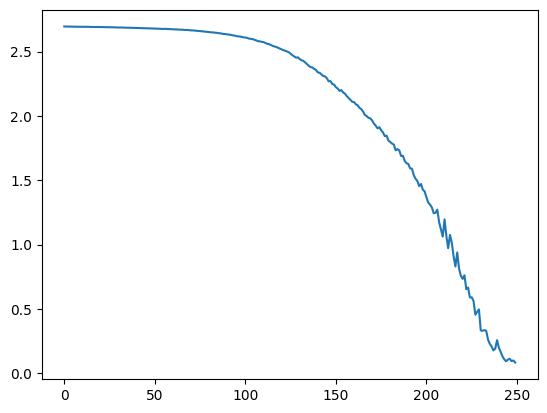

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# Testing the model

In [25]:
test_dataset = KineticsKeypointsDataset(meta=X_val, path=Path("data/keypoints"))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

Before: 750
Skipping  7LmsLfnAtTw
Skipping  zhX-VZrEil0
Skipping  0fCZ4MW3jYU
Skipping  0hpxpFsDuSA
Skipping  VEITXY7Hl8s
Skipping  9LPQS0C-v5s
Skipping  ZKFhlncm_ec
Skipping  l36lfrZOGY4
Skipping  0mTi_gr0e_Q
Skipping  _SyU7s7WUbE
Skipping  SIm_TNWBrHg
Skipping  8-kw-AIvyE4
Skipping  RGI-q_zmdAk
Skipping  WbiIkDWELVE
Skipping  lX-70GsXe4o
Skipping  mLlhy4a7yvY
Skipping  _ubj_hjLdVc
Skipping  2F0szQFICic
Skipping  0wwzMnMQTV0
Skipping  frq9eNYqKp4
Skipping  BQRNeNy1FLU
Skipping  lnfY8F-ygyk
Skipping  dtZwDqMYcs0
Skipping  ib_hIMo2zMg
Skipping  afPFwxSIRUE
Skipping  ThZssGhhi84
Skipping  M7l3_o8CG1Y
Skipping  DVl7vEAhzOY
Skipping  M4ZjXtidh_M
Skipping  ZDngOst5b9E
Skipping  dHxaqXFQ2q4
Skipping  8DNJ0iG6peo
Skipping  eC4otpBadSo
Skipping  780I7yhcMo4
Skipping  NQWyeunOWUs
Skipping  A2ETaXJsiZs
Skipping  W_RWXNEhzPU
Skipping  9K_QGLyH-Jk
Skipping  g9YY51X9NcY
Skipping  w6aMMgCiDNQ
Skipping  N0Ph13LsR5A
Skipping  xEpzW2OB2o0
Skipping  BHmjPU7lqKY
Skipping  yHnY9GCjt5E
Skipping  dIUkySTffY

In [50]:
def test(flag):
    if flag == 'train':
        n = len(train_dataset)
    elif flag == 'test':
        n = len(test_dataset)
    rnn.eval()
    with torch.no_grad():
        right = 0
        for i in range(n):
            inputs, category_tensor = randomTrainingExampleBatch(1,flag)
            category = int(category_tensor[0])
            inputs = inputs.to(device)
            output = rnn(inputs)
            guess, guess_i = categoryFromOutput(output)
            if category == guess_i:
                right+=1
            if i % 10 == 0:
                print(f"Guessed: {guess_i} {guess}, truth: {category} {train_dataset.labels[category]}")
    print(flag,'accuracy',right/n)

In [51]:
test('test')

Guessed: 9 dancing charleston, truth: 7 salsa dancing
Guessed: 5 dancing gangnam style, truth: 2 breakdancing
Guessed: 3 belly dancing, truth: 7 salsa dancing
Guessed: 13 jumpstyle dancing, truth: 4 dancing macarena
Guessed: 5 dancing gangnam style, truth: 11 swing dancing
Guessed: 3 belly dancing, truth: 4 dancing macarena
Guessed: 10 square dancing, truth: 10 square dancing
Guessed: 13 jumpstyle dancing, truth: 14 tap dancing
Guessed: 0 mosh pit dancing, truth: 7 salsa dancing
Guessed: 10 square dancing, truth: 9 dancing charleston
Guessed: 5 dancing gangnam style, truth: 4 dancing macarena
Guessed: 9 dancing charleston, truth: 8 dancing ballet
Guessed: 13 jumpstyle dancing, truth: 5 dancing gangnam style
Guessed: 11 swing dancing, truth: 1 country line dancing
Guessed: 7 salsa dancing, truth: 10 square dancing
Guessed: 9 dancing charleston, truth: 1 country line dancing
Guessed: 0 mosh pit dancing, truth: 6 tango dancing
Guessed: 10 square dancing, truth: 7 salsa dancing
Guessed: 13